In [40]:
# Alex Walczak | CS 189 | Homework 5 part 1: Decision Trees, Random Forests for Spam Data

# Import functions and libraries
from __future__ import division
import numpy as np, matplotlib.pyplot as plt
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.io
from scipy import signal
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import rcParams
from sklearn.cross_validation import KFold
rcParams['figure.figsize'] = 7, 7
%matplotlib inline

In [41]:
# def binarize(data):
#     # turns out, not a good idea...
#     # Binarize the features using Xij ← I(Xij > 0).
#     data[data > 0] = 1
#     data[data != 1] = 0
#     return data

In [42]:
# Recommended functions.
# 1. csv.DictReader
# If you use csv.DictReader, it will automatically parse out the header line in the
# csv file (first line of the file) and assign values to fields in a dictionary. 
# This can then be consumed by DictVectorizer to binarize categorical variables.

# 2. sklearn.feature_extraction.DictVectorizer (vectorizing categorical variables)
#     (There’s also sklearn.preprocessingOneHotEncoder, but it’s much less clean)

# 3. sklearn.preprocessing.LabelEncoder
#     (if you choose to discretize but not vectorize categorical variables)

# 4. sklearn.preprocessing.Imputer
#     (for inferring missing feature values in the preprocessing phase)

In [43]:
# Import data
sdata = scipy.io.loadmat("spam-dataset/spam_data.mat")
strain_data = sdata["training_data"] + 0.0
strain_labels = sdata["training_labels"][0,:]
stest_data = sdata["test_data"] + 0.0

In [44]:
# bstrain_data = binarize(strain_data)
# bstrain_labels = binarize(strain_labels)
# bstest_data = binarize(stest_data)

In [45]:
# Functions

In [46]:
from __future__ import print_function
# Save labels
def save_labels(labels, fname):
    f1 = open(fname, 'w+')
    print('Id,Category', file = f1)
    for i in range(len(labels)):
        print(str(i+1)+","+str(int(labels[i])), file = f1)
# save_labels(spam_labels,'kaggle_spam_mean.csv')

In [47]:
def probability(Y, C, S, distbn=None):
# probability of random variable Y being in class C
# index set S
    count = 0
    for i in S:
        if Y[int(i)] == C:
            count += 1
    return count/len(S)

def surprise(Y, C, S):
# surprise of random variable Y being in class C
    return -probability(Y, C, S)*((np.log(probability(Y, C, S)))/np.log(2))

def entropy(Y, classes, S):
# entropy of an index set S
# max = 1 occurs when Y is evenly split [ range = [0,1] ]
# (updating of entropy will be optimized, this is a naive version)
    H = 0
    for C in classes:
        H += surprise(Y, C, S)
    return H

def information_gain(Y, classes, S, Sleft, Sright):
    # change in entropy resulting from a split
    # we choose the split which maximizes this quanitity
    Hafter = (len(Sleft)*entropy(Y, classes, Sleft) + len(Sright)*entropy(Y, classes, Sright))/len(S)
    return entropy(Y, classes, S) - Hafter

def weighted_sum_of_entropy(Y, classes, S, Sleft, Sright):
    # we choose the split which MINimizes this quanitity
    Hafter = (len(Sleft)*entropy(Y, classes, Sleft) + len(Sright)*entropy(Y, classes, Sright))/len(S)
    return entropy(Y, classes, S) - Hafter

def gini_impurity(Y, classes, S):
    # Y can be thought of as a vector of labels, where a label equals a class C in classes.
    # we are only interested in the labels indexed by S. The other samples aren't being worked on.
    sum_prob_squared = 0
    for C in classes:
        sum_prob_squared+=(probability(Y, C, S)**2)
    return 1-sum_prob_squared

In [48]:
# Data Structure-related

In [49]:
# Thought: try cross validation on hyperparams.

In [50]:
### Pruning-related

In [51]:
def postprune(node, ogtree, tdata, tlabels):
    if node == None:
        return
    if node.label!=None:
        return
        
    postprune(node.left, ogtree, tdata, tlabels)
    postprune(node.right, ogtree, tdata, tlabels)
    
    error_before = np.sum(tlabels != ogtree.predict_all(tdata))/len(tlabels)
    testasleaf(node)
    error_after = np.sum(tlabels != ogtree.predict_all(tdata))/len(tlabels)

    if error_after <= error_before:
        converttoleaf(node)
    else:
        undotestasleaf(node)


def testasleaf(node):
    # if a node label is not None, the children are never looked at. 
    # so to prune, we can just set node labels!
    if int(np.rint(node.split_rule[1])) >= 1:
        node.label = 1
    else:
        node.label = 0

def undotestasleaf(node):
    node.label = None
    
def converttoleaf(node):
    node.left = None
    node.right = None
    node.split_rule = None

def countnodesandleaves(node):
    if node == None:
        return 0
    if node.label != None:
        return 1
    else:
        return 1 + countnodesandleaves(node.left) + countnodesandleaves(node.right)

In [65]:
class SpamTree:
    
    class Node:
        def __init__(self, left=None, right=None, label=None, split_rule=None):
            self.left = left
            self.right = right
            self.label = label
            self.split_rule = split_rule # (feature, threshhold)
    
    def __init__(self, SMALLEST_OK_LEAF=1):
        self.SMALLEST_OK_LEAF = SMALLEST_OK_LEAF
        self.root = self.Node()
        
    def segmenter(self, data, labels, depth):
        # A method that takes in data and labels. When called, it finds the best split rule
        # for a Node using the impurity measure and input data.
        
        # stopping conditions
        if len(labels) <= self.SMALLEST_OK_LEAF:
            return None
        
        if (np.sum(labels) == 0 or np.sum(labels) == len(labels)):
            return None
        
        num_features = len(data[0])
        
        # which feature to split on?
        impurities = np.zeros(num_features)
        for j in range(num_features):
            # suppose split on j, quantify the split quality.
            left_label_hist = [[0,0],[1,0]]
            right_label_hist = [[0,0],[1,0]]
                
            left_label_hist[1][1] = np.sum(labels[np.where(data[:,j] < np.mean(data[:,j]))]) # number of ones in left split
            right_label_hist[1][1] = np.sum(labels[np.where(data[:,j] >= np.mean(data[:,j]))])
            left_label_hist[0][1] = len(labels[np.where(data[:,j] < np.mean(data[:,j]))]) - left_label_hist[1][1] # number of zeros (is the rest of left data)
            right_label_hist[0][1] = len(labels[np.where(data[:,j] >= np.mean(data[:,j]))]) - right_label_hist[1][1]

            impurities[j] = self.WSE(left_label_hist, right_label_hist)
            if (np.isnan(impurities[j])):
                print('ENCOUNTERED NAN')
                print(left_label_hist, right_label_hist)
                
        if np.min(impurities) == 0:
            return None
        
        else:
            return np.argmin(impurities) # best feature
        
    def train(self, tree, data, labels, depth=2):
        # Grows a decision tree by constructing nodes.
        
        # A stopping condition (too deep or empty node)
        if depth <= 0 or len(data)==0:
            average = np.sum(labels)/len(labels)
            if average >= 0.5:
                label = 1
            else:
                label = 0
            tree.label = label
            return tree
        
        split_point = self.segmenter(data, labels, depth)
        if split_point == None:
            if int(np.rint(np.mean(labels))) >= 1:
                tree.label = 1
            else:
                tree.label = 0
        else:
            left_inds = np.where(data[:,split_point] < np.mean(data[:,split_point])) # maybe round up? nah
            right_inds = np.where(data[:,split_point] >= np.mean(data[:,split_point]))
            left_data = data[left_inds]
            right_data = data[right_inds]
            left_labels = labels[left_inds]
            right_labels = labels[right_inds]
            tree.split_rule = (split_point, np.mean(data[:,split_point]))
            tree.left = self.train(self.Node(), left_data, left_labels, depth-1)
            tree.right = self.train(self.Node(), right_data, right_labels, depth-1)
        return tree

    def predict(self, data, show=False, i=5):
        # Traverses the tree to find the best label to classify the data point.
        cur_node = self.root
        origi = i
        while (cur_node.label == None and i):
            split_point = cur_node.split_rule[0]
            thresh = cur_node.split_rule[1]
            if show:
                print(origi-i+1, split_point, data[split_point], thresh)
                i-=1
            if (data[split_point] < thresh):
                cur_node = cur_node.left
            else:
                cur_node = cur_node.right
            if (cur_node.label>1):
                print(cur_node.split_rule)
                print(cur_node.label)
        return int(cur_node.label)
    
    def predict_all(self, test_data):
        predns = [0,0]
        pred_labels = []
        errors = 0
        for i in range(len(test_data)):
            sample = test_data[i]
            predn = self.predict(sample)
            if predn > 1:
                print(predn)
            predns[predn] += 1
            pred_labels += [predn]
        plt.stem(predns)
        plt.xlim([-.2,1.2])
        plt.title('Number of each class')
#         print('Preidcted Spam : Total ratio =', predns[1]/len(test_data))
        return np.array(pred_labels)
    
    def WSE(self, left_label_hist, right_label_hist):
        return self.weighted_sum_of_entropy(left_label_hist, right_label_hist)
    
    def weighted_sum_of_entropy(self, left_label_hist, right_label_hist):
        # we choose the split which MINimizes this quanitity
        # for spam, two hists may be: ex. [( (0, 134), (1, 57)), ( (0, 12), (1, 19))]
        # card_X -> cardinality of X histogram
        card_left = left_label_hist[0][1] + left_label_hist[1][1]
        card_right = right_label_hist[0][1] + right_label_hist[1][1]
        return (card_left*self.entropy(left_label_hist) + card_right*self.entropy(right_label_hist))/(card_left+card_right+1e-11)
    
    def entropy(self, hist):
        # of a node, often a proposed node.
        # hist = (...,(feature_i, frequency),...)
        total = hist[0][1] + hist[1][1] + 1e-15
        prob0 = hist[0][1]/total
        prob1 = hist[1][1]/total
        return prob0*self.surprise(prob0) + prob1*self.surprise(prob1)
        
    def surprise(self, probability):
        return -((np.log(probability + 1e-15))/np.log(2))

    def impurity(self, left_label_hist, right_label_hist):
    # A method that takes in the result of a split: two histograms (a histogram is a mapping
    # from label values to their frequencies) that count the frequencies of labels on the ”left”
    # and ”right” side of that split. The method calculates and outputs a scalar value
    # representing the impurity (i.e. the ”badness”) of the specified split on the input data.
    # for spam: ( (0, 134), (1, 57))
        card_left = left_label_hist[0][1] + left_label_hist[1][1]
        card_right = right_label_hist[0][1] + right_label_hist[1][1]
        return ((card_left)*(gini_impurity(left_label_hist)) + (card_right)*(gini_impurity(right_label_hist)))/(card_left+card_right+1e-13)
    
def gini_impurity(hist):
    # Y can be thought of as a vector of labels, where a label equals a class C in classes.
    # we are only interested in the labels indexed by S. The other samples aren't being worked on.
    sum_prob_squared = 0
    card = hist[0][1] + hist[1][1]
    sum_prob_squared = (hist[0][1]/(card+1e-13))**2 + (hist[1][1]/(card+1e-13))**2
    return 1-sum_prob_squared

def avg_prediction(trees, data):
    predicted_labels = []
    for tree in trees:
        predicted_labels += [tree.predict_all(data)]
    predicted_labels = np.array([predicted_labels])
    return np.rint(np.mean(predicted_labels, axis = 1))

# st.WSE(((0,13),(1,4)),((0,1),(1,12))) # test :D

In [55]:
# Build a set of "differently pruned" trees. (saw no improvement.)

rand_inds = np.random.permutation(len(strain_data))
KFprune = KFold(rand_inds[4500:].shape[0], n_folds=3, shuffle = True)

best_smallest_leaf_permitted = 2
best_depth = 60
pruned_trees = []

training_data = strain_data[rand_inds[:4500]]
training_labels = strain_labels[rand_inds[:4500]]

#selecting different pruning sets
for unused, prune_inds in KFprune:
    
    inds = rand_inds[4500:][prune_inds]
    
    prune_data = strain_data[inds]
    prune_labels = strain_labels[inds]

    spam_tree = SpamTree(best_smallest_leaf_permitted)
    spam_tree.train(spam_tree.root, training_data, training_labels, best_depth)

    postprune(spam_tree.root, spam_tree, prune_data, prune_labels)
    
    pruned_trees += [spam_tree]
    print('bark!')

In [72]:
test_spam = strain_data[rand_inds[400:900]]
test_spam_labels = strain_labels[rand_inds[400:900]]

avg_pdn = avg_prediction(pruned_trees, test_spam)
np.sum(avg_pdn != test_spam_labels)/len(test_spam_labels)

/Library/Python/2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Library/Python/2.7/site-packages/numpy/core/_methods.py:69: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


1.0

In [ ]:
# Tests without pruning.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in long_scalars


Error 0.112722351121


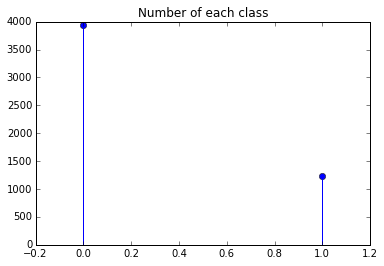

In [66]:
best_smallest_leaf_permitted = 27
best_depth = 39
st = SpamTree(best_smallest_leaf_permitted)
st.train(st.root, strain_data, strain_labels, best_depth)

predn_labels = st.predict_all(strain_data);
print('Error', np.sum(predn_labels != strain_labels)/len(strain_labels))

In [68]:
# st.predict(strain_data[666], show = True)

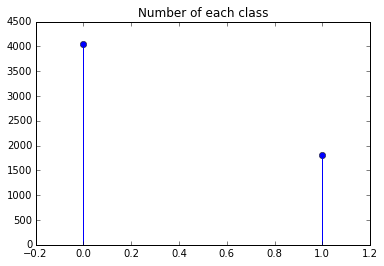

In [1389]:
st.predict_all(stest_data);

In [ ]:
### start find best depth ###

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in long_scalars


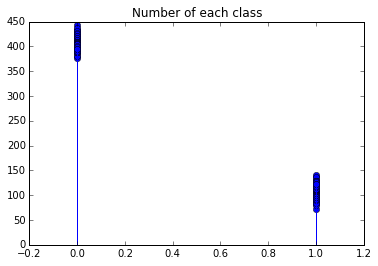

In [1312]:
kf = KFold(strain_data.shape[0], n_folds=10, shuffle = True)

depths = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,39,45,55,60]
depth_errors = np.zeros(len(depths))
smallest_leaf_permitted = 29
for i in range(len(depths)):
    for train, test in kf:
        ktrain = strain_data[train]
        ktrain_label = strain_labels[train]
        ktest = strain_data[test]
        ktrue = strain_labels[test]
        
        st = SpamTree(smallest_leaf_permitted)
        st.train(st.root, ktrain, ktrain_label, depths[i])
        predn_labels = st.predict_all(ktest);
        depth_errors[i]+=(np.sum(predn_labels != ktrue)/len(ktrue))*0.1

In [1316]:
depths[np.argmin(depth_errors)] # 39

39

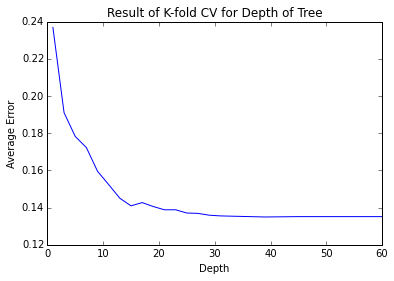

In [1313]:
plt.plot(depths, depth_errors)
plt.title('Result of K-fold CV for Depth of Tree')
plt.xlabel('Depth')
plt.ylabel('Average Error')

In [1719]:
## deeeeep
depths = [25,29,35,39,45,55,60,64,70,78,80,88]
depth_errors = np.zeros(len(depths))
smallest_leaf_permitted = 2
for i in range(len(depths)):
    for train, test in kf:
        ktrain = strain_data[train]
        ktrain_label = strain_labels[train]
        ktest = strain_data[test]
        ktrue = strain_labels[test]
        
        st = SpamTree(smallest_leaf_permitted)
        st.train(st.root, ktrain, ktrain_label, depths[i])
        predn_labels = st.predict_all(ktest);
        depth_errors[i]+=(np.sum(predn_labels != ktrue)/len(ktrue))*0.1
    print(i)

In [1714]:
print(depths[np.argmin(depth_errors)])

45


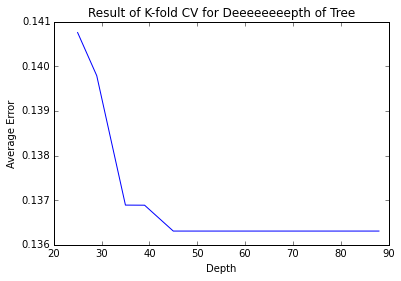

In [1711]:
plt.plot(depths, depth_errors)
plt.title('Result of K-fold CV for Deeeeeeeepth of Tree') # min at depth = 45
plt.xlabel('Depth')
plt.ylabel('Average Error')

In [ ]:
### end find best depth ### result 

In [1314]:
# General Testing of a hyperparameter.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in long_scalars


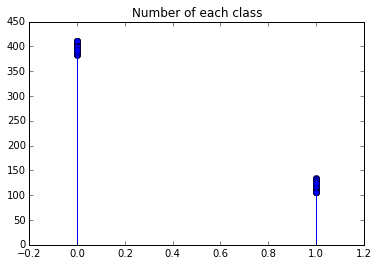

In [1317]:
hyperparam = [1,2,3,4,5,6,7,8,9,10,11,13,15,17,19,21,23,25,27,29,40,50] # smallest_leaf_ok
hyperp_errors = np.zeros(len(hyperparam))
for i in range(len(hyperparam)):
    
    smallest_leaf_permitted = hyperparam[i] ## set hyperparam
    
    for train, test in kf:
        ktrain = strain_data[train]
        ktrain_label = strain_labels[train]
        ktest = strain_data[test]
        ktrue = strain_labels[test]
        
        st = SpamTree(smallest_leaf_permitted)
        st.train(st.root, ktrain, ktrain_label, 39) # used 39 depth, best smallest_leaf_permitted = 29
        predn_labels = st.predict_all(ktest);
        hyperp_errors[i]+=(np.sum(predn_labels != ktrue)/len(ktrue))*0.1

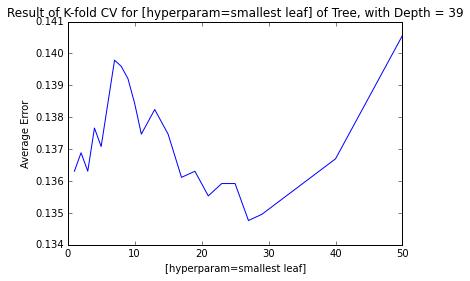

In [1321]:
plt.plot(hyperparam, hyperp_errors)
# plt.xlim([0.2,23.2])
plt.title('Result of K-fold CV for [hyperparam=smallest leaf] of Tree, with Depth = 39')
plt.xlabel('[hyperparam=smallest leaf]')
plt.ylabel('Average Error')

In [1319]:
hyperparam[np.argmin(hyperp_errors)]

27

In [ ]:
### end test hyperparam ###

In [ ]:
### Scratch Work Below ###

In [ ]:
# from lecture on 2016-03-14; confirmation of result at 1:01:05 in webcast.

In [ ]:
classes = [0, 1]
yy = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1])
ss = np.linspace(0, len(yy)-1, len(yy))
ssleft = np.linspace(0,16,17, dtype=int)
ssright = np.linspace(17,len(yy)-1,len(yy)-17, dtype=int)

In [ ]:
entropy(yy, classes, ssleft)

In [ ]:
entropy(yy, classes, ssright)

In [ ]:
information_gain(yy, classes, ss, ssleft, ssright)

In [ ]:
gini_impurity(yy, classes, ss)

In [ ]:
# we are breaking the index set S into pieces as we build the tree. Y containing our output classes is unchanged.
# we make splits that maximize the information gain, which is measured using three index sets.

In [1658]:
#     print('# before:',countnodesandleaves(atree.root))
#     predn_labels = atree.predict_all(ktest);
#     error_before = np.sum(ktrue != predn_labels)/len(ktrue)
#     print('Error before', error_before)

#     postprune(atree.root, atree, prune_data, prune_labels)

#     print('# after:',countnodesandleaves(atree.root))
#     predn_labels = atree.predict_all(ktest);
#     error_after = np.sum(ktrue != predn_labels)/len(ktrue)
#     print('Error after', error_after)

In [81]:
class SpamRandomForest:
    
    # features are all binarized, and we have only two classes.
    class Node:
        def __init__(self, left=None, right=None, label=None, split_rule=None):
            self.left = left
            self.right = right
            self.label = label
            self.split_rule = split_rule # (feature, threshhold)
    
    def __init__(self, SMALLEST_OK_LEAF=1, m=7):
        # random subset features used at each split, size equals "m" in range [1,d].
        self.m = m
        self.SMALLEST_OK_LEAF = SMALLEST_OK_LEAF
        self.root = self.Node()
        
    def segmenter(self, data, labels, depth):
        # A method that takes in data and labels. When called, it finds the best split rule
        # for a Node using the impurity measure and input data.
        
        # stopping conditions
        if len(labels) <= self.SMALLEST_OK_LEAF:
            return None
        
        if (np.sum(labels) == 0 or np.sum(labels) == len(labels)):
            return None
        
#         features = np.random.permutation(len(data[0])-1)[:self.m] changed below
        features = np.random.permutation(len(data[0]))[:self.m]
        
        # which feature to split on?
        impurities = np.zeros(len(features))
        for imp_idx in range(len(features)):
            j = features[imp_idx]
            # suppose split on j, quantify the split quality.
            left_label_hist = [[0,0],[1,0]]
            right_label_hist = [[0,0],[1,0]]
                
            left_label_hist[1][1] = np.sum(labels[np.where(data[:,j] < np.mean(data[:,j]))]) # number of ones in left split
            right_label_hist[1][1] = np.sum(labels[np.where(data[:,j] >= np.mean(data[:,j]))])
            left_label_hist[0][1] = len(labels[np.where(data[:,j] < np.mean(data[:,j]))]) - left_label_hist[1][1] # number of zeros (is the rest of left data)
            right_label_hist[0][1] = len(labels[np.where(data[:,j] >= np.mean(data[:,j]))]) - right_label_hist[1][1]
            
#             print(features)
            impurities[imp_idx] = checknan = self.WSE(left_label_hist, right_label_hist)

            if (np.isnan(checknan)):
                print('ENCOUNTERED NAN')
                print(left_label_hist, right_label_hist)
                
        if np.min(impurities) == 0:
            return None
        
        else:
            return features[np.argmin(impurities)] # best feature
        
    def train(self, tree, data, labels, depth=2):
        # Grows a decision tree by constructing nodes.
        
        # A stopping condition (too deep or empty node)
        if depth <= 0 or len(data)==0:
            average = np.sum(labels)/len(labels)
            if average >= 0.5:
                label = 1
            else:
                label = 0
            tree.label = label
            return tree
        
        split_point = self.segmenter(data, labels, depth)
        if split_point == None:
            if int(np.rint(np.mean(labels))) >= 1:
                tree.label = 1
            else:
                tree.label = 0
        else:
            left_inds = np.where(data[:,split_point] < np.mean(data[:,split_point])) # maybe round up? nah
            right_inds = np.where(data[:,split_point] >= np.mean(data[:,split_point]))
            left_data = data[left_inds]
            right_data = data[right_inds]
            left_labels = labels[left_inds]
            right_labels = labels[right_inds]
            tree.split_rule = (split_point, np.mean(data[:,split_point]))
            tree.left = self.train(self.Node(), left_data, left_labels, depth-1)
            tree.right = self.train(self.Node(), right_data, right_labels, depth-1)
        return tree

    def predict(self, data, show=False, i=5):
        # Traverses the tree to find the best label to classify the data point.
        cur_node = self.root
        origi = i
        if show:
            wohs = []
        while (cur_node.label == None and i):
            split_point = cur_node.split_rule[0]
            thresh = cur_node.split_rule[1]
            if show:
                wohs += [ (split_point, data[split_point], thresh) ]
                print(origi-i+1, split_point, data[split_point], thresh)
                i-=1
            if (data[split_point] < thresh):
                cur_node = cur_node.left
            else:
                cur_node = cur_node.right
            if (cur_node.label>1):
                print(cur_node.split_rule)
                print(cur_node.label)
        if show:
            return wohs
        return int(cur_node.label)
    
    def predict_all(self, test_data):
        predns = [0,0]
        pred_labels = []
        errors = 0
        for i in range(len(test_data)):
            sample = test_data[i]
            predn = self.predict(sample)
            if predn > 1:
                print(predn)
            predns[predn] += 1
            pred_labels += [predn]
        plt.stem(predns)
        plt.xlim([-.2,1.2])
        plt.title('Number of each class')
        return np.array(pred_labels)
    
    def WSE(self, left_label_hist, right_label_hist):
        return self.weighted_sum_of_entropy(left_label_hist, right_label_hist)
    
    def weighted_sum_of_entropy(self, left_label_hist, right_label_hist):
        # we choose the split which MINimizes this quanitity
        # for spam, two hists may be: ex. [( (0, 134), (1, 57)), ( (0, 12), (1, 19))]
        # card_X -> cardinality of X histogram
        card_left = left_label_hist[0][1] + left_label_hist[1][1]
        card_right = right_label_hist[0][1] + right_label_hist[1][1]
        return (card_left*self.entropy(left_label_hist) + card_right*self.entropy(right_label_hist))/(card_left+card_right+1e-11)
    
    def entropy(self, hist):
        # of a node, often a proposed node.
        # hist = (...,(feature_i, frequency),...)
        total = hist[0][1] + hist[1][1] + 1e-15
        prob0 = hist[0][1]/total
        prob1 = hist[1][1]/total
        return prob0*self.surprise(prob0) + prob1*self.surprise(prob1)
        
    def surprise(self, probability):
        return -((np.log(probability + 1e-15))/np.log(2))

    def impurity(self, left_label_hist, right_label_hist):
    # A method that takes in the result of a split: two histograms (a histogram is a mapping
    # from label values to their frequencies) that count the frequencies of labels on the ”left”
    # and ”right” side of that split. The method calculates and outputs a scalar value
    # representing the impurity (i.e. the ”badness”) of the specified split on the input data.
    # for spam: ( (0, 134), (1, 57))
        card_left = left_label_hist[0][1] + left_label_hist[1][1]
        card_right = right_label_hist[0][1] + right_label_hist[1][1]
        return ((card_left)*(gini_impurity(left_label_hist)) + (card_right)*(gini_impurity(right_label_hist)))/(card_left+card_right+1e-13)
    
def gini_impurity(hist):
    # Y can be thought of as a vector of labels, where a label equals a class C in classes.
    # we are only interested in the labels indexed by S. The other samples aren't being worked on.
    sum_prob_squared = 0
    card = hist[0][1] + hist[1][1]
    sum_prob_squared = (hist[0][1]/(card+1e-13))**2 + (hist[1][1]/(card+1e-13))**2
    return 1-sum_prob_squared


# st.WSE(((0,13),(1,4)),((0,1),(1,12))) # test :D

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in long_scalars


Error 0.084


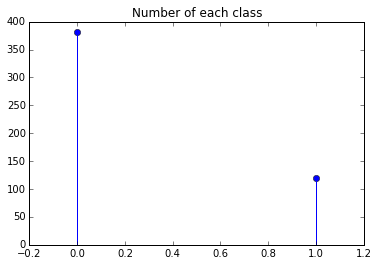

In [73]:
forest_depth = 37
biggest_stopping_point = 1
m = 23

st = SpamRandomForest(biggest_stopping_point,m)
st.train(st.root, strain_data, strain_labels, forest_depth)
predn_labels = st.predict_all(test_spam);
print('Error', np.sum(predn_labels != test_spam_labels)/len(test_spam_labels))

Error 0.0771461716937


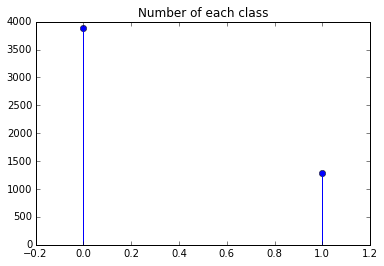

In [76]:
predn_labels = st.predict_all(strain_data);
print('Error', np.sum(predn_labels != strain_labels)/len(strain_labels))

In [77]:
# Find best m (size of split subset)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in long_scalars


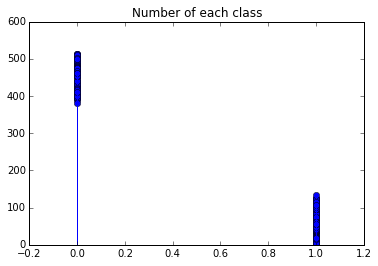

In [38]:
ms = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,39,45,49]
m_errors = np.zeros(len(ms))

forest_depth = 37
biggest_stopping_point = 1

kf = KFold(strain_data.shape[0], n_folds=10, shuffle = True)

for i in range(len(ms)):
    for train, test in kf:
        ktrain = strain_data[train]
        ktrain_label = strain_labels[train]
        ktest = strain_data[test]
        ktrue = strain_labels[test]

        srf = SpamRandomForest(biggest_stopping_point, ms[i])
        srf.train(srf.root, ktrain, ktrain_label, forest_depth)

        predn_labels = srf.predict_all(ktest);
        m_errors[i] += (np.sum(predn_labels != ktrue)/len(ktrue))*0.1

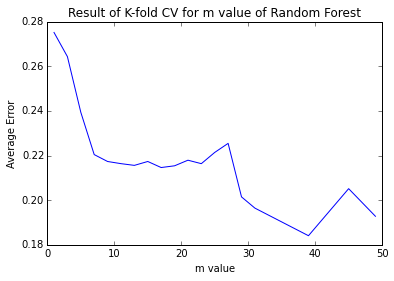

In [39]:
plt.plot(ms, m_errors)
plt.title('Result of K-fold CV for m value of Random Forest')
plt.xlabel('m value')
plt.ylabel('Average Error')

In [40]:
print(ms[np.argmin(m_errors)])

39


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in long_scalars


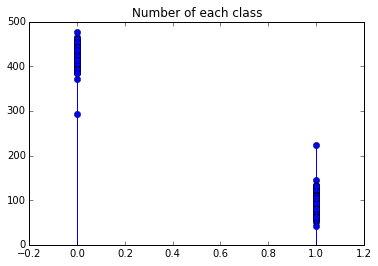

In [43]:
hyperparam = [1,2,3,4,5,6,7,8,9,10,11,13,15,17,19,21,23,25,27,29,40,50] # smallest_leaf_ok
hyp_errors = np.zeros(len(hyperparam))
forest_depth = 37
best_m = 39

for i in range(len(hyperparam)):
    for train, test in kf:
        ktrain = strain_data[train]
        ktrain_label = strain_labels[train]
        ktest = strain_data[test]
        ktrue = strain_labels[test]

        srf = SpamRandomForest(hyperparam[i], best_m)
        srf.train(srf.root, ktrain, ktrain_label, forest_depth)

        predn_labels = srf.predict_all(ktest);
        hyp_errors[i] += (np.sum(predn_labels != ktrue)/len(ktrue))*0.1

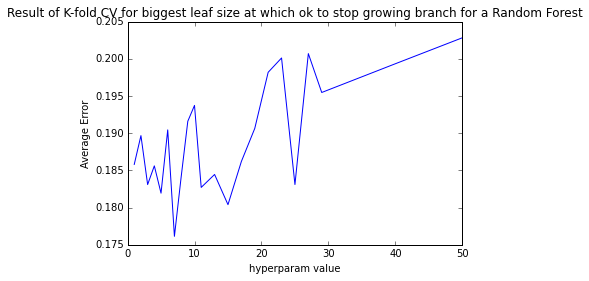

In [44]:
plt.plot(hyperparam, hyp_errors)
plt.title('Result of K-fold CV for biggest leaf size at which ok to stop growing branch for a Random Forest')
plt.xlabel('hyperparam value')
plt.ylabel('Average Error')

In [46]:
print(hyperparam[np.argmin(hyp_errors)])

7


In [47]:
# Ensemble learning

In [5]:
def avg_prediction(trees, data):
    predicted_labels = []
    for tree in trees:
        predicted_labels += [tree.predict_all(data)]
    predicted_labels = np.array([predicted_labels])
    return np.rint(np.mean(predicted_labels, axis = 1))

In [14]:
# Build a set of differently sampled forests. n = n'.

best_stopping_point = 7
forest_depth = 37
best_m = 39
woods = []
errors = []

number_of_forests = 40

rand_test_inds = np.random.permutation(len(strain_data))[:880]
random_test_data = strain_data[rand_test_inds]
random_test_labels = strain_labels[rand_test_inds]

# Select different sampled sets.
for i in range(number_of_forests):
    
    bagged_inds = np.random.choice(len(strain_data), size=len(strain_data), replace=True)
    
    training_set = []
    training_labels = []
    for j in bagged_inds:
        training_set += [strain_data[j]]
        training_labels += [strain_labels[j]]
    training_set = np.array(training_set)
    training_labels = np.array(training_labels)

    spam_rf = SpamRandomForest(best_stopping_point, best_m)
    spam_rf.train(spam_rf.root, training_set, training_labels, forest_depth)
    
    woods += [spam_rf]
    
    avg_pdn = avg_prediction(woods, random_test_data)
    error = np.sum(avg_pdn != random_test_labels)/len(random_test_labels)
    print(i+1, error)
    errors += [error]

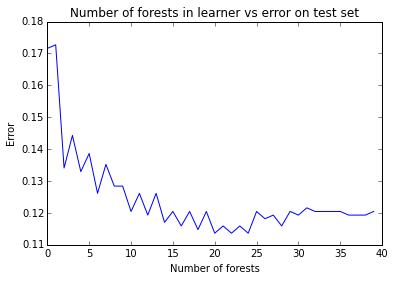

In [72]:
plt.plot(np.arange(number_of_forests), errors)
plt.title('Number of forests in learner vs error on test set')
plt.ylabel('Error')
plt.xlabel('Number of forests')

In [91]:
np.argmin(errors)

20

In [11]:
def generate_inds(data, percent_train, with_replacement=False):
    if not with_replacement:
        rand_inds = np.random.permutation(len(data))
        train_inds = rand_inds[len(data)//percent_train:]
        test_inds = rand_inds[:len(data)//percent_train]
    else:
        train_inds = np.random.choice(len(data), size=len(data), replace=True)
        test_inds = np.random.permutation(len(data))[:len(data)//percent_train]
    return train_inds, test_inds

def avg_prediction(trees, data):
    predicted_labels = []
    for tree in trees:
        predicted_labels += [tree.predict_all(data)]
    predicted_labels = np.array([predicted_labels])
    return np.rint(np.mean(predicted_labels, axis = 1))

def grow_set_trees(num_trees, percent_train, data, labels, treetype='DecisionTree', depth=None, m=None, size_to_stop=None, bagging=False, prune=False):
    trees = []
    for t in range(num_trees):
        print(t+1)
        train_inds, unused = generate_inds(data, percent_train, with_replacement=bagging)
        training = data[train_inds]
        training_labels = labels[train_inds]

        if treetype == 'RandomForest':
            tree = SpamRandomForest(size_to_stop, m)
  
        tree.train(tree.root, data, labels, depth)

        if prune:
            XXX, prune_inds = generate_inds(data, percent_train)
            pruneset = data[prune_inds]
            prune_labels = labels[prune_inds]
            postprune(tree.root, tree, pruneset, prune_labels)

        trees += [tree]
    return trees

In [92]:
# Build a set of differently sampled forests. n = n'.

best_stopping_point = 7
forest_depth = 37
best_m = 39

number_of_forests = 20 # best result

# Select different sampled sets.
for i in range(number_of_forests):
    
    bagged_inds = np.random.choice(len(strain_data), size=len(strain_data), replace=True)
    
    training_set = []
    training_labels = []
    for j in bagged_inds:
        training_set += [strain_data[j]]
        training_labels += [strain_labels[j]]
    training_set = np.array(training_set)
    training_labels = np.array(training_labels)

    kaggle_spam_rf = SpamRandomForest(best_stopping_point, best_m)
    kaggle_spam_rf.train(kaggle_spam_rf.root, training_set, training_labels, forest_depth)
    
    woods += [kaggle_spam_rf]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in long_scalars


1


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in long_scalars


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Error of 20 random forests: 0.109090909091


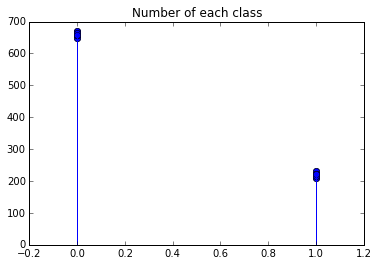

In [82]:
num_trees = 20
pt = 10
treetype = 'RandomForest'
depth = 37
m = 8
size_to_stop = 7
bagging = True
prune = False

random_forests = grow_set_trees(num_trees, pt, strain_data, strain_labels, treetype, depth, m, size_to_stop, bagging, prune)

avg_predn_forests_labels = avg_prediction(random_forests, random_test_data)
print('Error of 20 random forests:', np.sum(avg_predn_forests_labels != random_test_labels)/len(random_test_labels))

In [85]:
# seen = []
# for r in random_forests:
#     seen+=[r.predict(strain_data[666],show=True)]

In [22]:
# # ('Error of 20 pruned forests:', 0.125)
# pruned_forests = []
# count = 0
# for rf in random_forests:
    
#     print('before', count, countnodesandleaves(rf.root))
    
#     XXX, prune_inds = generate_inds(strain_data, pt)
#     pruneset = strain_data[prune_inds]
#     prune_labels = strain_labels[prune_inds]
#     postprune(rf.root, rf, pruneset, prune_labels)
    
#     print('after', count, countnodesandleaves(rf.root))

#     pruned_forests += [rf]
#     count+=1

# avg_predn_pruned_forests_labels = avg_prediction(pruned_forests, random_test_data)
# print('Error of 20 pruned forests:', np.sum(avg_predn_pruned_forests_labels != random_test_labels)/len(random_test_labels))

ERROR! Session/line number was not unique in database. History logging moved to new session 1082


In [38]:
# 0.77418 Kaggle Score for Spam Data

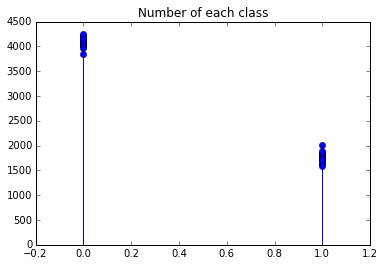

In [32]:
kaggle_spam_pdn_labels = np.array(avg_prediction(random_forests, stest_data))[0]
save_labels(kaggle_spam_pdn_labels, 'spam_random_forest_666999.csv')
np.sum(kaggle_spam_pdn_labels)/len(kaggle_spam_pdn_labels)